In [6]:
!pip install torchsampler
!pip install xgboost
!pip install torchmetrics
!pip install pytorch_lightning
!pip install optuna
!pip install memory_profiler

In [10]:
!git clone https://github.com/jalpv1//genres
!rm -rf ./genres/.git


Cloning into 'genres'...
remote: Enumerating objects: 28984, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 28984 (delta 0), reused 0 (delta 0), pack-reused 28982 (from 2)
Receiving objects: 100% (28984/28984), 2.93 GiB | 9.72 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (26187/26187), done.


In [7]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 84.0 MB/s eta 0:00:00:00:0100:01


In [8]:
!pip install scikit-learn
!pip install matplotlib
! pip install imageio
! pip install cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 134.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 105.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 162.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 40.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [1]:
import cv2
from skimage import feature

def rgb_to_cielab(image):
    #print(np.shape(image))
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

def rgb_to_cieluv(image):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

def rgb_to_hsv(image):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
def rgb_to_cieYCrCb(image):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

def extract_color_features(image):
    features = []
    for color_space_func in [rgb_to_cielab, rgb_to_cieYCrCb, rgb_to_hsv]:
        transformed_image = color_space_func(image)
        mean = np.mean(transformed_image, axis=(0, 1))
        std = np.std(transformed_image, axis=(0, 1))
        features.extend(mean)
        features.extend(std)
    return features

def extract_lbp(image):
   image = np.transpose(image, (1, 2, 0))
   image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   sample_detailed = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
   sample_broad = feature.local_binary_pattern(image, P=24, R=3, method='uniform')
   hist_detailed = np.histogram(sample_detailed, bins=10)[0]
   hist_broad = np.histogram(sample_broad, bins=26)[0]
   return  np.concatenate([hist_detailed, hist_broad])

def extract_color_palette(image, num_colors=5):
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image
    pixels = image_rgb.reshape((-1, 3))
    pixels = np.float32(pixels)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None,
                                    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                    attempts=10,
                                    flags=cv2.KMEANS_RANDOM_CENTERS)
   # print(centers)
    centroids = centers.flatten().tolist()

    return  centroids

def extract_features(model, train_loader):
  features = []
  labels_ = []
  map_img_feature = {}
  for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      feature = model(inputs)
      #print(feature)

      #feature = feature.mean((2,3)).squeeze()
      transformer_feature = feature.squeeze(0).detach().cpu().numpy()

      print(f"transformer_feature - {np.shape(transformer_feature)}")
      color_feature = extract_color_features(inputs.squeeze().detach().cpu().numpy())
      color_palette = extract_color_palette(inputs.squeeze().detach().cpu().numpy(), num_colors=15)
      lbp_features = extract_lbp(inputs.squeeze().detach().cpu().numpy())
      concatenated_vector = np.concatenate((transformer_feature, color_feature, color_palette, lbp_features))
      print(f"concated vector  - {np.shape(concatenated_vector)}")
      features.append(concatenated_vector)
      # no clustering
      # concatenated_vector = np.concatenate((cnn_feature, color_feature))
      # features.append(concatenated_vector)
      labels_.append(labels.cpu().numpy())
      print("----------------------------------")

  return features, labels_, map_img_feature


In [2]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e
from sklearn.model_selection import StratifiedKFold, cross_val_score


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cpu'

num_classes = 10


Python 3.11.6
/usr/bin/sh: line 1: nvcc: command not found
Source files will be saved in "/tmp/tmp1wplcaey".


In [12]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.1/481.1 kB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 77.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import timm

class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name: str = "vit_base_patch16_224", layer_name: str = "blocks.6", extract_cls: bool = True):
        """
        Extract features from a specified layer of a Vision Transformer (ViT).

        :param model_name: The name of the ViT model from `timm`
        :param layer_name: The layer from which to extract features (e.g., "blocks.6")
        :param extract_cls: If True, return only the CLS token feature
        """
        super(ViTFeatureExtractor, self).__init__()

        # Load pretrained ViT model from timm
        self.model = timm.create_model(model_name, pretrained=True)
        self.layer_name = layer_name
        self.extract_cls = extract_cls  # Flag for CLS token extraction
        self.activations = dict()

        # Define hook function
        def hook(module, input, output):
            self.activations[layer_name] = output  # Store output of the hooked layer

        # Register hook on the specified layer
        layer = dict(self.model.named_modules())[layer_name]
        layer.register_forward_hook(hook)

    def forward(self, x):
        """
        Forward pass through the ViT model, capturing activations from the specified layer.

        :param x: Input image tensor of shape (batch_size, 3, 224, 224)
        :return: Extracted features from the specified layer (CLS token if extract_cls=True)
        """
        _ = self.model(x)  # Run forward pass
        features = self.activations[self.layer_name]  # Extracted features

        if self.extract_cls:
            return features[:, 0]  # Extract only CLS token (first token)
        return features  # Return full features

device = 'cpu'

model = ViTFeatureExtractor().to(device)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import  numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import psutil
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
)
def precision_recall_draw(y_true, y_score):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve

    y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])

    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def roc_draw(y_true, y_score):
  from sklearn.preprocessing import label_binarize
  plt.figure(figsize=(15, 10))
  y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])


  for i, class_name in enumerate(class_names):
     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')


  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()


def evaluate_model(y_true, y_pred, y_pred_proba):
    report_dict = classification_report(y_pred, y_true, target_names=class_names, output_dict=True)
    metrics_df2 = pd.DataFrame(report_dict).transpose()
    print(metrics_df2)
    print("-----------------------------------------------------------------------------------------------------------")

    precision_recall_draw(y_true, y_pred_proba)
    roc_draw(y_true, y_pred_proba)
    cm =confusion_matrix(y_true, y_pred, normalize = 'true')
    #cm_percent_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    
    disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)  
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Not normalized Confusion Matrix")
    plt.show()
class_names = ['abstract','animal-painting','cityscape', 'flower-painting','landscape','marina','nude-painting-nu','portrait','religious-painting','still-life']

model_name ="transformer_2_genres"
cv = 5

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
data = ArtStyleDataset('genres', transform)

dataset = dl.data_load(data)
train_data , train_labels,map_img_feature = extract_features(model, dataset)
dl.save_pickle(train_data,train_labels, model_name + " trans_genres")

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

transformer_feature - (768,)
concated vector  - (867,)
----------------------------------


/opt/conda/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transforme

In [4]:
! pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 130.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 62.1 MB/s eta 0:00:00


In [5]:
X_train shape: (14804, 1)
y_train shape: (14804, 867)

SyntaxError: invalid syntax (305587937.py, line 1)

1. Transformer Parameter Search

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                    precision    recall  f1-score      support
abstract             0.949919  0.949919  0.949919   619.000000
animal-painting      0.841823  0.902299  0.871012   348.000000
cityscape            0.885470  0.899306  0.892334   576.000000
flower-painting      0.916890  0.892950  0.904762   383.000000
landscape            0.892283  0.893720  0.893001   621.000000
marina               0.948127  0.924157  0.935989   356.000000
nude-painting-nu     0.954023  0.937097  0.945484   620.000000
portrait             0.925990  0.925990  0.925990   581.000000
religious-painting   0.910873  0.906028  0.908444   564.000000
still-life           0.927817  0.924561  0.926186   570.000000
accuracy             0.916953  0.916953  0.916953     0.916953
macro avg            0.915322  0.915603  0.915312  5238.000000
weighted avg         0.917502  0.916953  0.917120  5238.000000
-----------------------------------------------------------------------------------------------------------


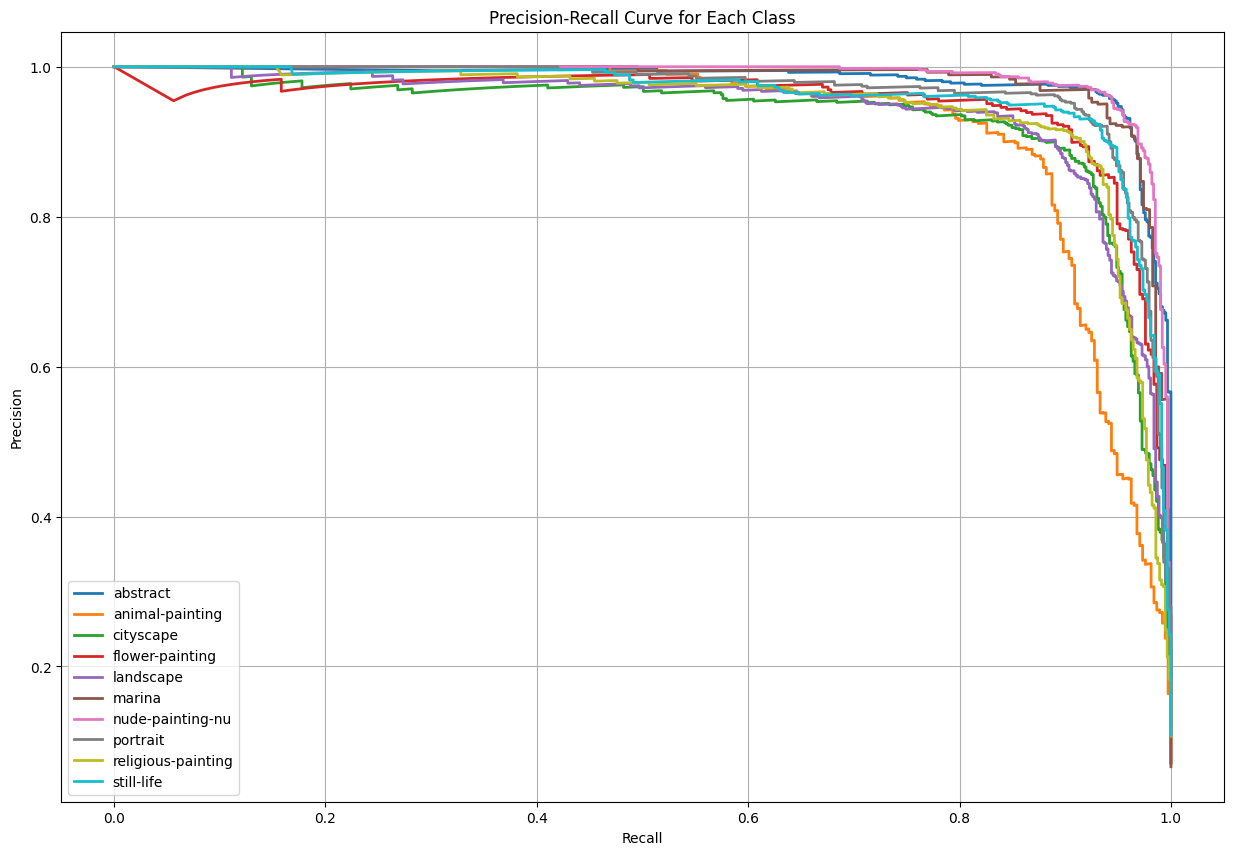

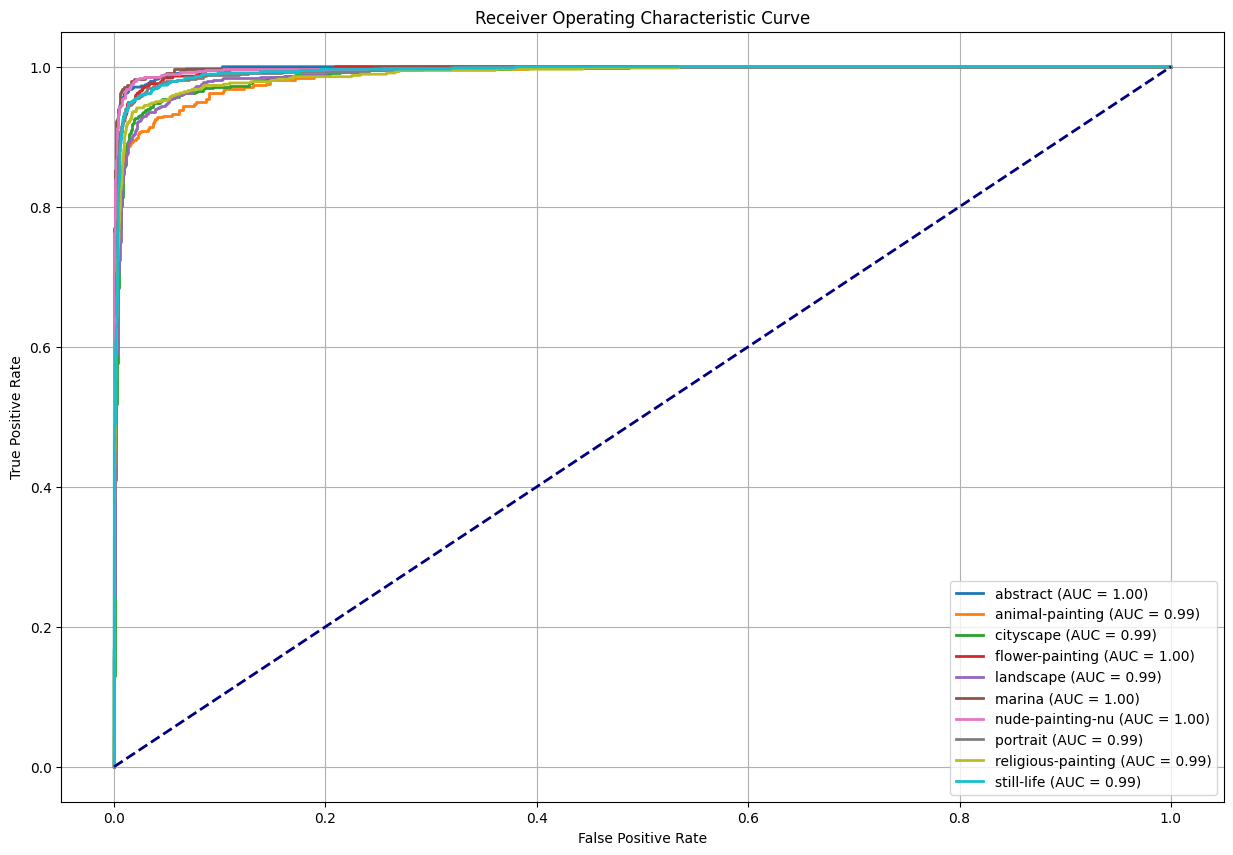

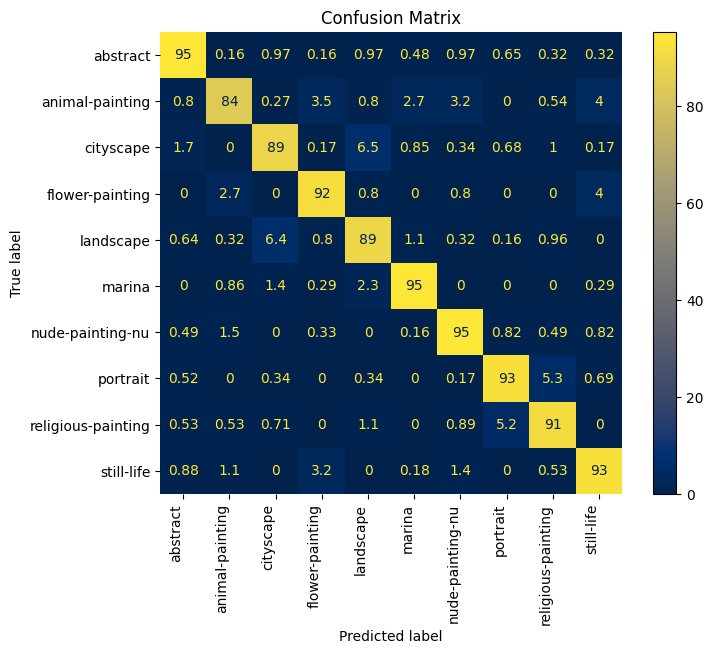

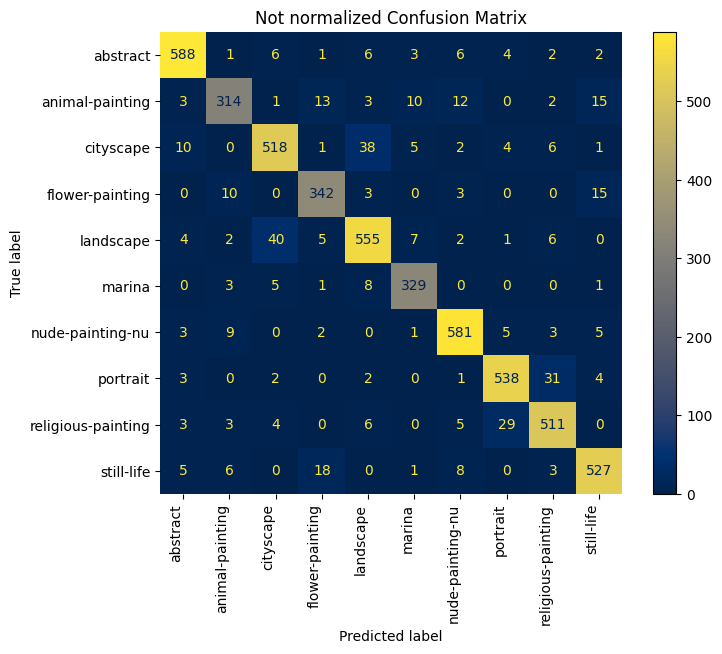

In [6]:
from sklearn.neural_network import MLPClassifier

best_mlp = MLPClassifier(
    hidden_layer_sizes=(490, 221, 116),
    solver="lbfgs",  
    learning_rate="adaptive",  
    learning_rate_init=0.0019296907971858555,  
    alpha=2.0617072079456476e-06, 
    batch_size=64, 
    activation="relu",  
    max_iter=303, 
    early_stopping=True,  
    random_state=42  
)
best_mlp.fit(X_train_scaled, y_train)
frmodel_pred = best_mlp.predict(X_test_scaled)
frmodel_pred_proba = best_mlp.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)



In [7]:
best_mlp = MLPClassifier(
    hidden_layer_sizes=(490, 221, 116),
    solver="lbfgs",  
    learning_rate="adaptive",  
    learning_rate_init=0.0019296907971858555,  
    alpha=2.0617072079456476e-06,  
    batch_size=64,  
    activation="relu", 
    max_iter=303,  
    early_stopping=True,  
    random_state=42  
)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  best_mlp , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.918357  0.918289  0.918310  0.918289   46.823817   
1         2   0.916036  0.915998  0.915988  0.915998   45.846194   
2         3   0.918249  0.917701  0.917823  0.917701   46.929926   
3         4   0.915173  0.914646  0.914785  0.914646   45.957156   
4         5   0.915773  0.915982  0.915766  0.915982   44.377807   
5   Average   0.916718  0.916523  0.916534  0.916523   45.986980   
6  1.581139   0.001481  0.001466  0.001480  0.001466    1.024645   

   Prediction time  
0         0.105378  
1         0.093866  
2         0.063746  
3         0.090509  
4         0.065443  
5         0.083789  
6         0.018379  


In [8]:
from sklearn.svm import SVC
svc_model = SVC(
    kernel='poly', 
    C=39.55159458196473, 
    gamma=0.06924486730918748, 
    degree=3, 
    random_state=42
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  svc_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.920931  0.920008  0.920153  0.920008  117.935802   
1         2   0.919027  0.918099  0.918268  0.918099  106.939371   
2         3   0.923918  0.922475  0.922759  0.922475  108.489432   
3         4   0.921729  0.920756  0.920921  0.920756  101.820148   
4         5   0.914382  0.913500  0.913548  0.913500  108.690115   
5   Average   0.919997  0.918967  0.919130  0.918967  108.774974   
6  1.581139   0.003596  0.003436  0.003512  0.003436    5.825559   

   Prediction time  
0        25.488176  
1        30.335061  
2        26.386519  
3        26.366192  
4        24.357062  
5        26.586602  
6         2.253716  


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                    precision    recall  f1-score      support
abstract             0.933764  0.949097  0.941368   609.000000
animal-painting      0.844504  0.872576  0.858311   361.000000
cityscape            0.892308  0.896907  0.894602   582.000000
flower-painting      0.922252  0.927224  0.924731   371.000000
landscape            0.898714  0.901613  0.900161   620.000000
marina               0.948127  0.953623  0.950867   345.000000
nude-painting-nu     0.937603  0.974403  0.955649   586.000000
portrait             0.925990  0.948854  0.937282   567.000000
religious-painting   0.909091  0.913978  0.911528   558.000000
still-life           0.970070  0.862285  0.913007   639.000000
accuracy             0.919626  0.919626  0.919626     0.919626
macro avg            0.918242  0.920056  0.918751  5238.000000
weighted avg         0.920377  0.919626  0.919534  5238.000000
-----------------------------------------------------------------------------------------------------------


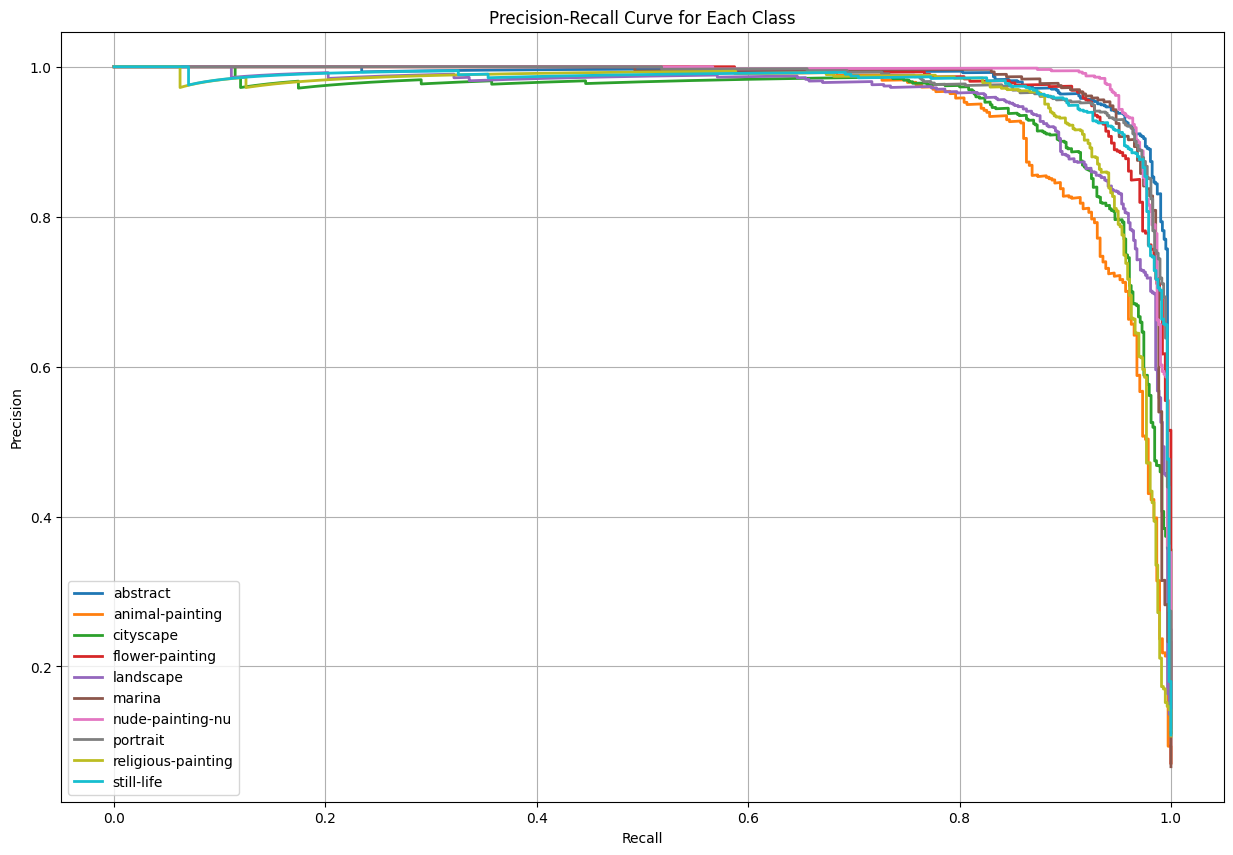

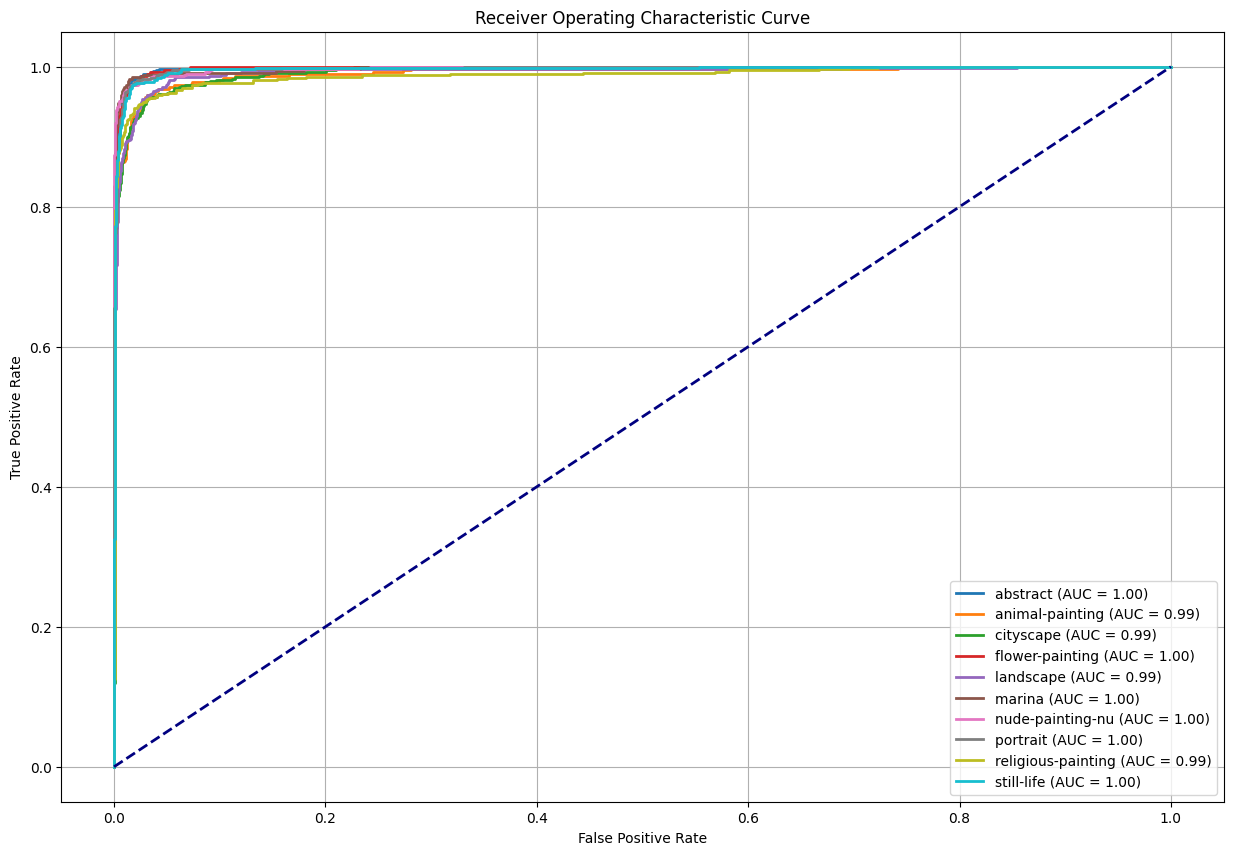

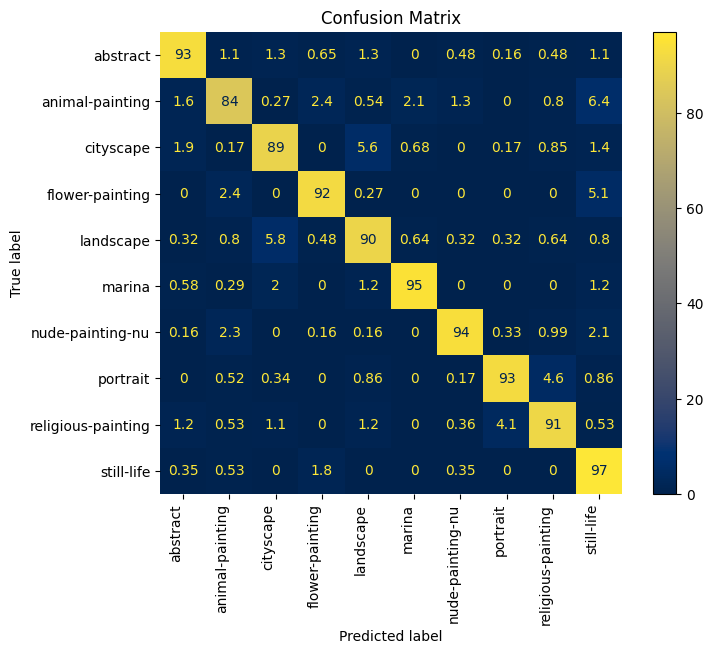

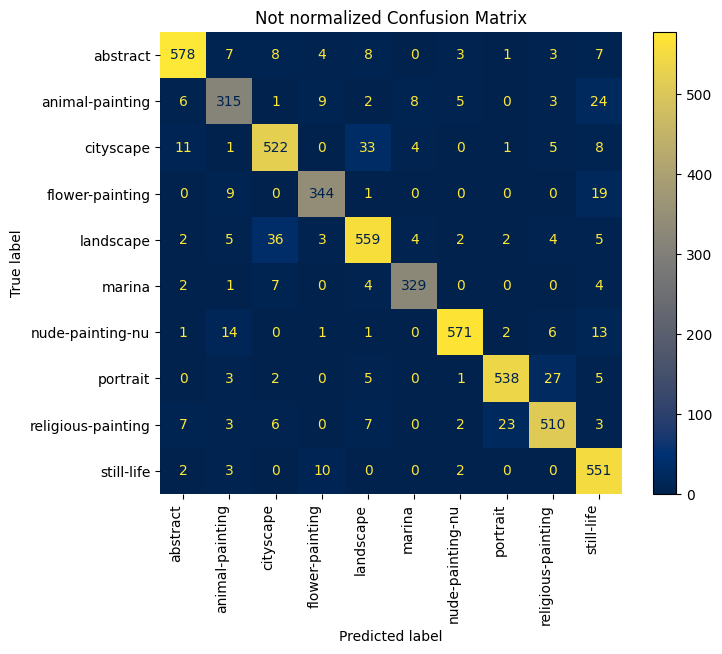

In [9]:
from sklearn.svm import SVC

svc_model = SVC(
    kernel='poly', 
    C=39.55159458196473, 
    gamma=0.06924486730918748, 
    degree=3, 
    random_state=42,
    probability = True
)

svc_model.fit(X_train_scaled, y_train)
frmodel_pred = svc_model.predict(X_test_scaled)
frmodel_pred_proba = svc_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [14]:
a = 0
a

0

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                    precision    recall  f1-score      support
abstract             0.936995  0.897833  0.916996   646.000000
animal-painting      0.747989  0.920792  0.825444   303.000000
cityscape            0.873504  0.850250  0.861720   601.000000
flower-painting      0.873995  0.893151  0.883469   365.000000
landscape            0.893891  0.876972  0.885350   634.000000
marina               0.864553  0.914634  0.888889   328.000000
nude-painting-nu     0.922824  0.970639  0.946128   579.000000
portrait             0.915663  0.907850  0.911740   586.000000
religious-painting   0.850267  0.873626  0.861789   546.000000
still-life           0.929577  0.812308  0.866995   650.000000
accuracy             0.887934  0.887934  0.887934     0.887934
macro avg            0.880926  0.891805  0.884852  5238.000000
weighted avg         0.890720  0.887934  0.888104  5238.000000
-----------------------------------------------------------------------------------------------------------


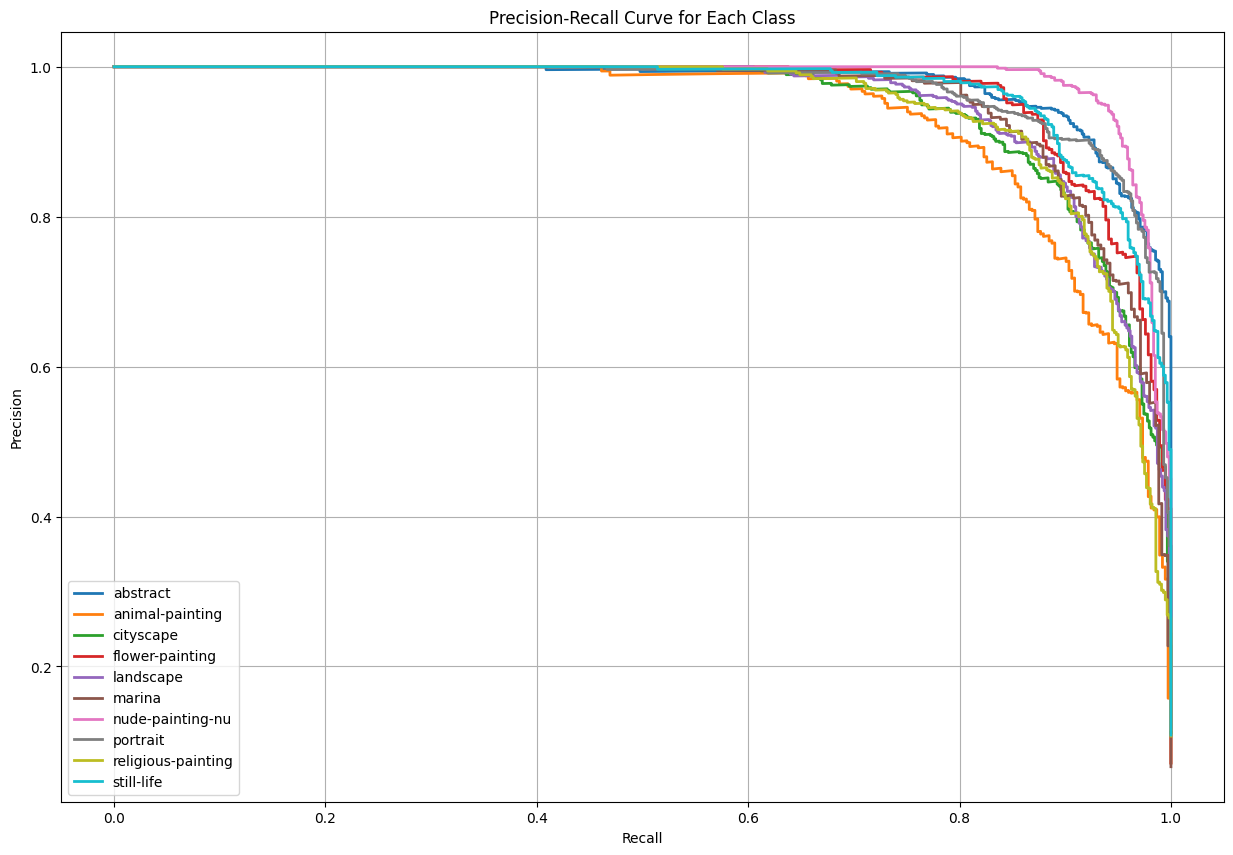

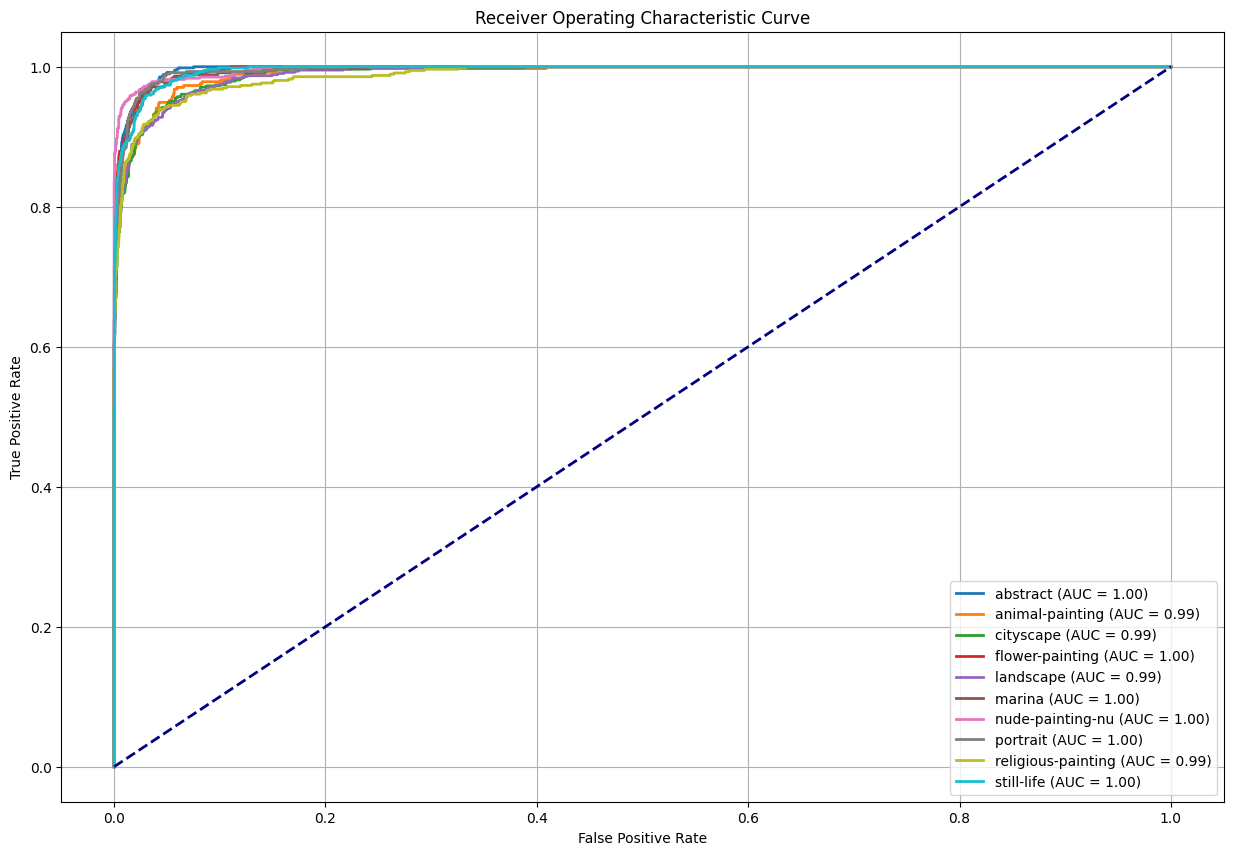

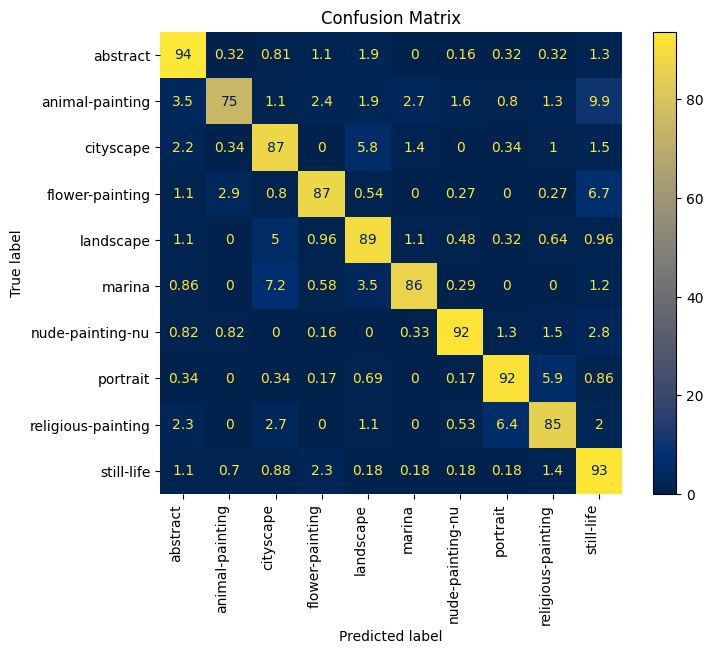

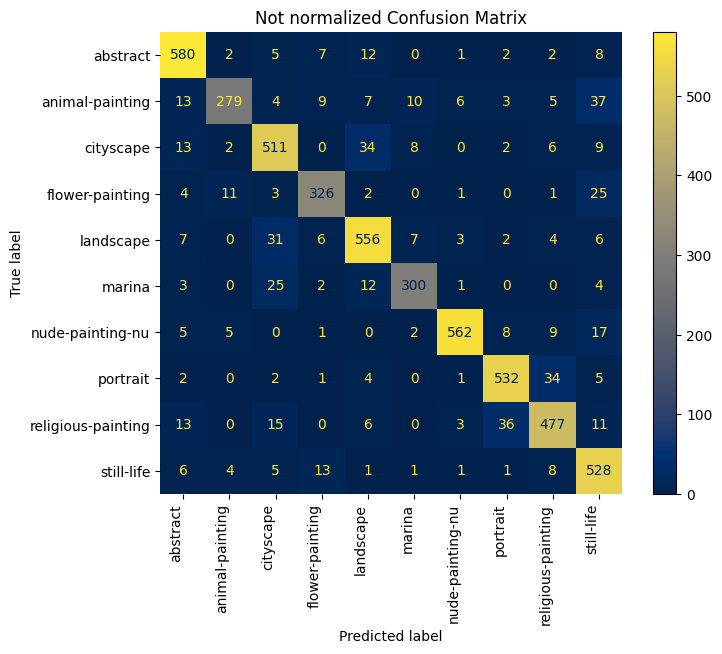

In [10]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(
    n_estimators=900,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    criterion='entropy',
    random_state=42,
    n_jobs=-1  # Use all cores for faster training
)

best_rf.fit(X_train_scaled, y_train)
frmodel_pred = best_rf.predict(X_test_scaled)
frmodel_pred_proba = best_rf.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [11]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  best_rf , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.900643  0.898435  0.898090  0.898435   52.695551   
1         2   0.887638  0.886025  0.885739  0.886025   51.956094   
2         3   0.891933  0.889441  0.889113  0.889441   51.814958   
3         4   0.896764  0.894596  0.894537  0.894596   52.457739   
4         5   0.883368  0.880657  0.880481  0.880657   52.291995   
5   Average   0.892069  0.889831  0.889592  0.889831   52.243267   
6  1.581139   0.006909  0.006992  0.006978  0.006992    0.360156   

   Prediction time  
0         0.322836  
1         0.239349  
2         0.307290  
3         0.239250  
4         0.297609  
5         0.281267  
6         0.039354  


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:43:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                    precision    recall  f1-score      support
abstract             0.951535  0.927559  0.939394   635.000000
animal-painting      0.849866  0.885475  0.867305   358.000000
cityscape            0.895726  0.885135  0.890399   592.000000
flower-painting      0.892761  0.904891  0.898785   368.000000
landscape            0.897106  0.919275  0.908055   607.000000
marina               0.945245  0.929178  0.937143   353.000000
nude-painting-nu     0.939245  0.971138  0.954925   589.000000
portrait             0.934596  0.931389  0.932990   583.000000
religious-painting   0.903743  0.892606  0.898140   568.000000
still-life           0.938380  0.911111  0.924545   585.000000
accuracy             0.917144  0.917144  0.917144     0.917144
macro avg            0.914820  0.915776  0.915168  5238.000000
weighted avg         0.917499  0.917144  0.917195  5238.000000
-----------------------------------------------------------------------------------------------------------


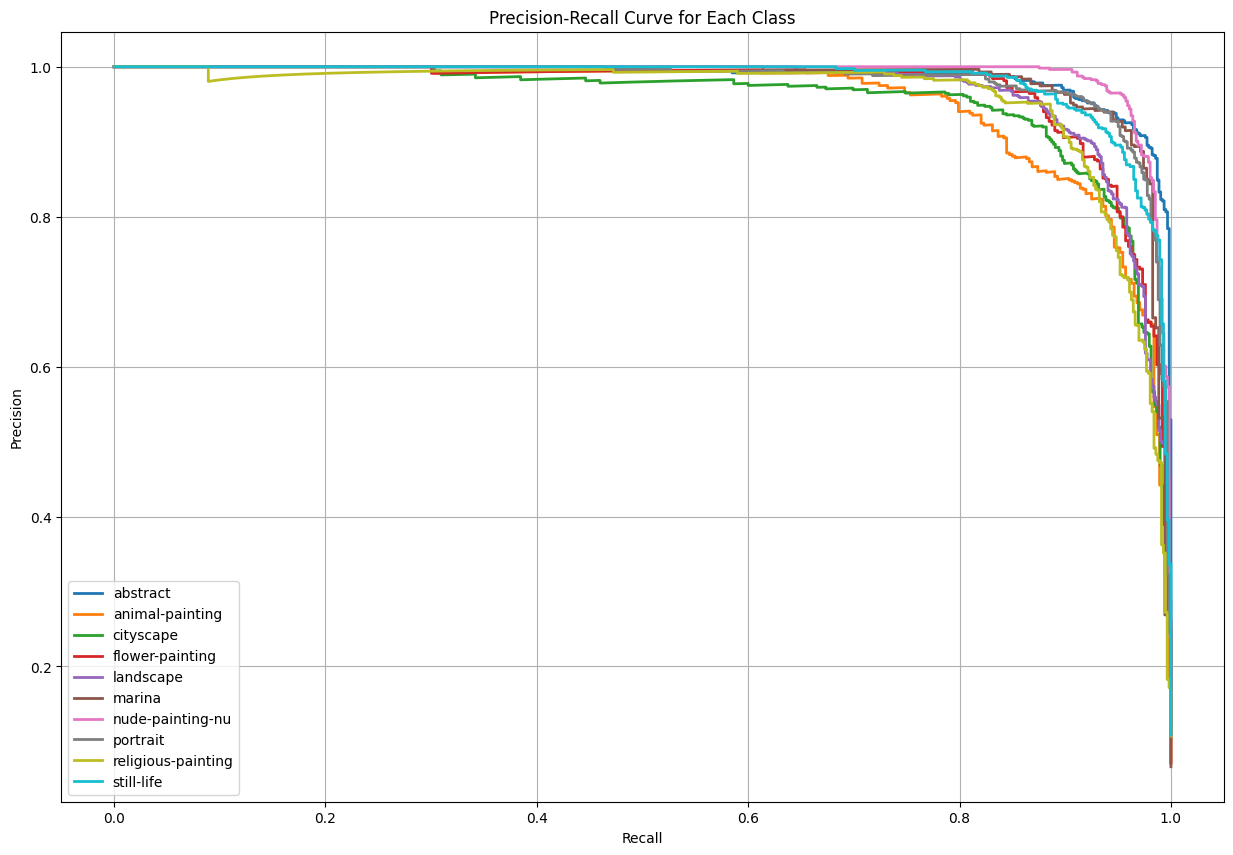

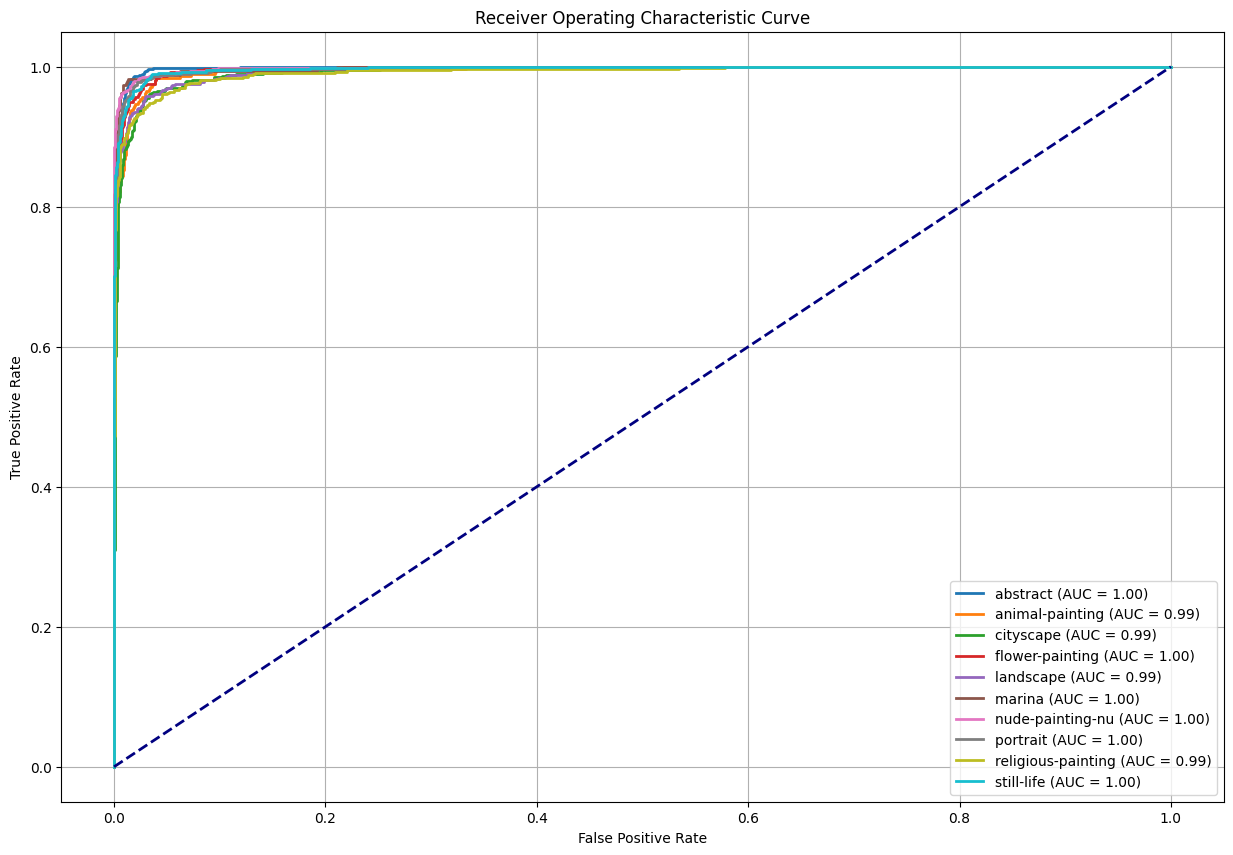

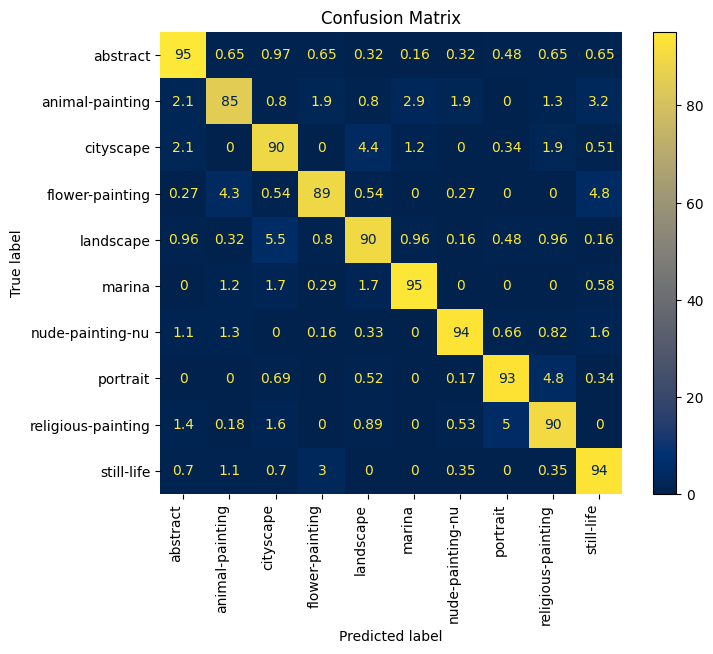

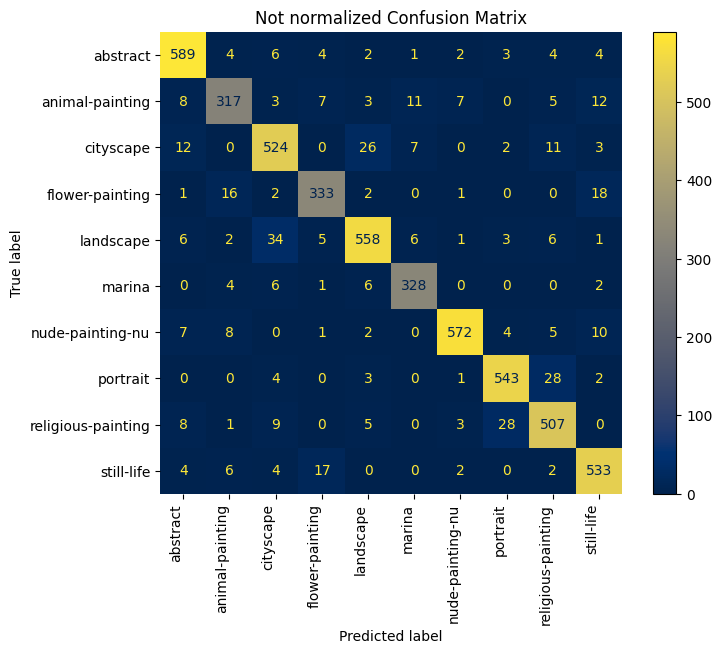

In [12]:
import xgboost as xgb

best_xgb = xgb.XGBClassifier(
    n_estimators=900,
    max_depth=4,
    learning_rate=0.17404904511951427,
    subsample=0.7846029675418292,
    colsample_bytree=0.7100830138794556,
    gamma=0.0264969818078781,
    reg_lambda=0.3460029118030738,
    reg_alpha=0.17069404218780862,
    objective='multi:softprob', 
    use_label_encoder=False,
    eval_metric='mlogloss',  
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train_scaled, y_train)
frmodel_pred = best_xgb.predict(X_test_scaled)
frmodel_pred_proba = best_xgb.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [13]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  best_xgb , 1)
print(avg)

/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:46:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:48:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:50:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:52:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:55:01] WARNING: /w

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.919443  0.919244  0.919201  0.919244  127.449485   
1         2   0.913328  0.913326  0.913181  0.913326  127.521885   
2         3   0.920350  0.919801  0.919858  0.919801  124.117113   
3         4   0.924188  0.923811  0.923831  0.923811  128.098573   
4         5   0.910318  0.910063  0.909883  0.910063  124.272869   
5   Average   0.917525  0.917249  0.917191  0.917249  126.291985   
6  1.581139   0.005604  0.005491  0.005584  0.005491    1.931523   

   Prediction time  
0         0.027499  
1         0.028320  
2         0.025317  
3         0.032591  
4         0.023651  
5         0.027476  
6         0.003397  


/opt/conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


                    precision    recall  f1-score      support
abstract             0.919225  0.903175  0.911129   630.000000
animal-painting      0.766756  0.864048  0.812500   331.000000
cityscape            0.846154  0.859375  0.852713   576.000000
flower-painting      0.906166  0.847118  0.875648   399.000000
landscape            0.848875  0.872727  0.860636   605.000000
marina               0.907781  0.860656  0.883590   366.000000
nude-painting-nu     0.916256  0.942568  0.929226   592.000000
portrait             0.882960  0.896853  0.889853   572.000000
religious-painting   0.903743  0.856419  0.879445   592.000000
still-life           0.892606  0.881739  0.887139   575.000000
accuracy             0.881252  0.881252  0.881252     0.881252
macro avg            0.879052  0.878468  0.878188  5238.000000
weighted avg         0.882667  0.881252  0.881521  5238.000000
-----------------------------------------------------------------------------------------------------------


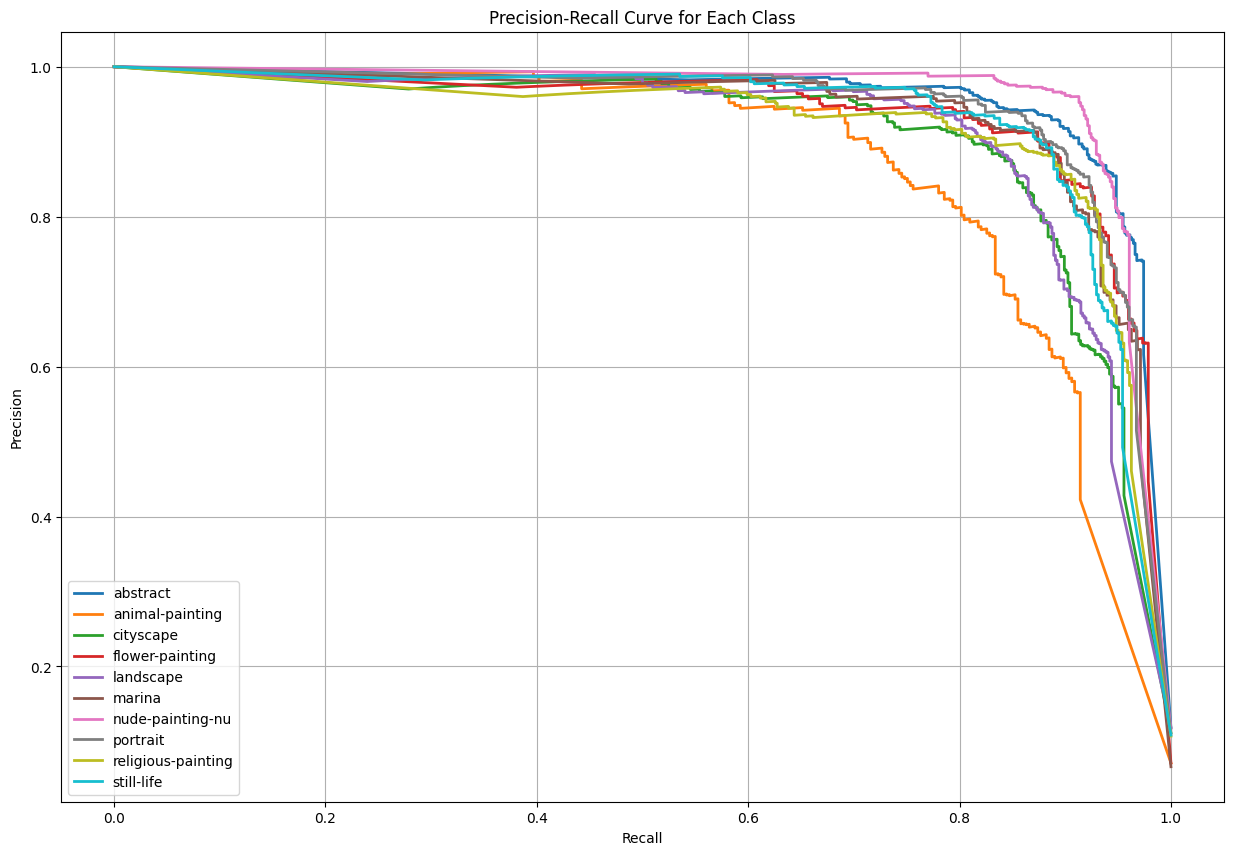

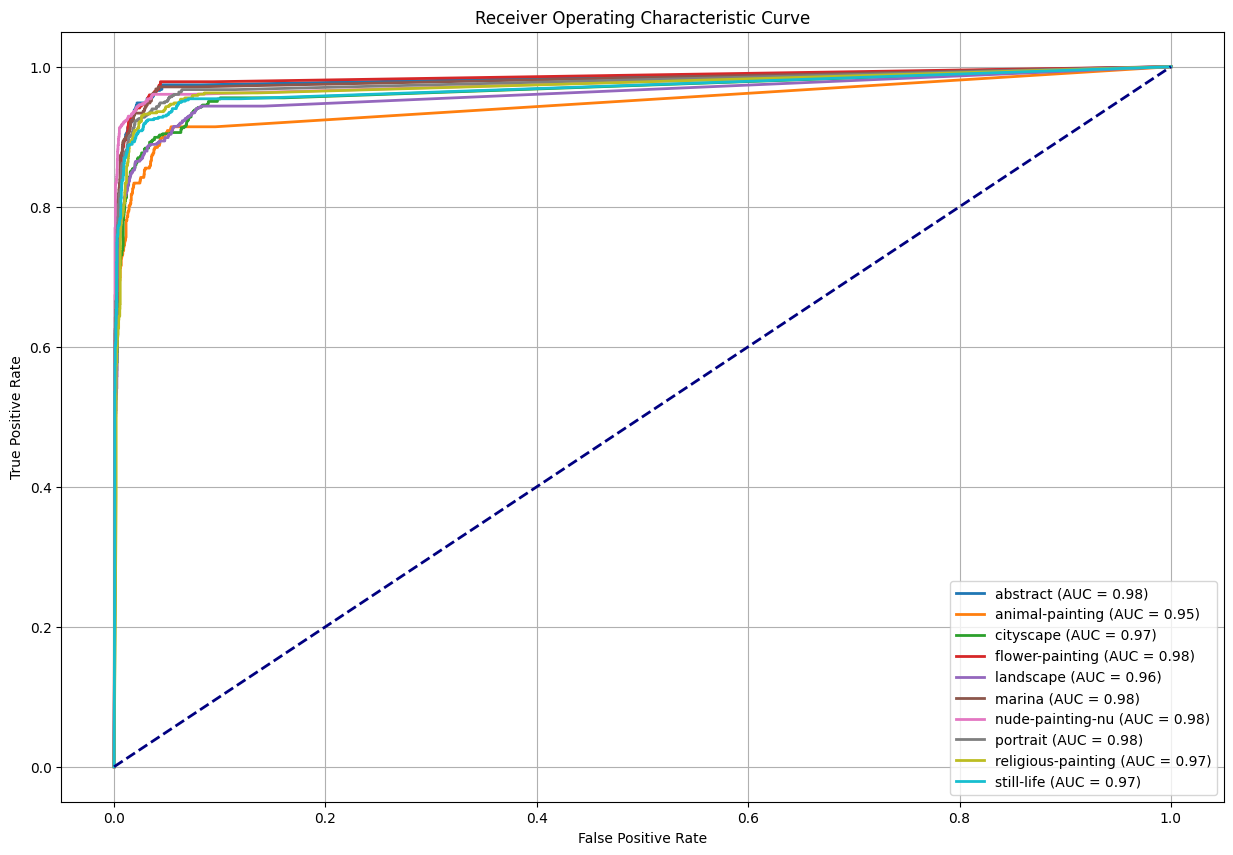

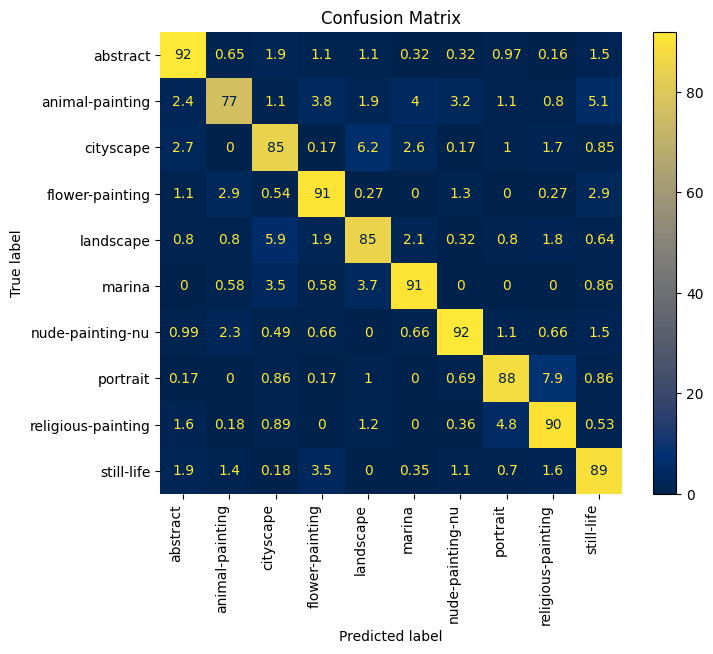

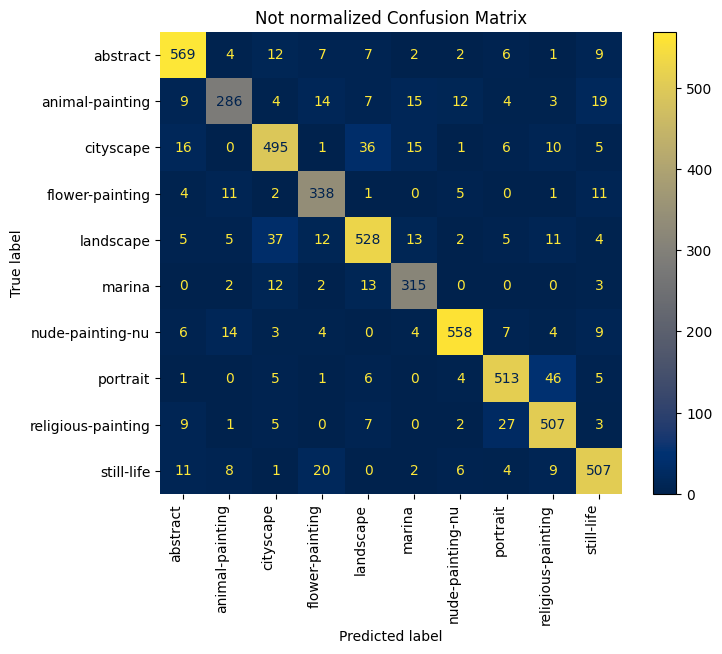

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    metric='cosine',
    algorithm='brute',
    n_neighbors=6,
    weights='distance',
    leaf_size=30,
    p=2  
)

knn_model.fit(X_train_scaled, y_train)
frmodel_pred = knn_model.predict(X_test_scaled)
frmodel_pred_proba = knn_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [15]:
knn_model = KNeighborsClassifier(
    metric='cosine',
    algorithm='brute',
    n_neighbors=6,
    weights='distance',
    leaf_size=30,
    p=2  
)


avg= e.kfold_crossvalidation(train_data, train_labels, 5,  knn_model , 1)
print(avg)
print("....")

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.891381  0.891180  0.891181  0.891180    0.024801   
1         2   0.874855  0.874570  0.874369  0.874570    0.026600   
2         3   0.881820  0.881612  0.881455  0.881612    0.025560   
3         4   0.876348  0.875501  0.875572  0.875501    0.026789   
4         5   0.872141  0.871873  0.871245  0.871873    0.026551   
5   Average   0.879309  0.878947  0.878764  0.878947    0.026060   
6  1.581139   0.007616  0.007711  0.007866  0.007711    0.000851   

   Prediction time  
0         1.319590  
1         1.318310  
2         1.327308  
3         1.310463  
4         1.313168  
5         1.317768  
6         0.006503  
....
